In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import scoreatpercentile
%matplotlib inline

In [4]:
#ToDo
# bhattacharrya distance (imp myself)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  3.]),
 array([ 0.        ,  0.09357781,  0.18715561,  0.28073342,  0.37431123,
         0.46788903,  0.56146684,  0.65504465,  0.74862245,  0.84220026,
         0.93577807]),
 <a list of 10 Patch objects>)

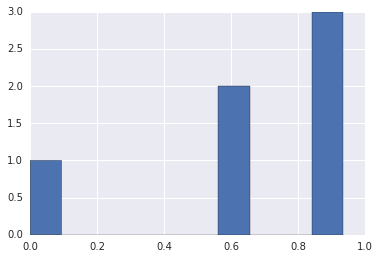

In [42]:
# Sample Data

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',    
]

# featurize
vectorizer = TfidfVectorizer(min_df=1)
results = vectorizer.fit_transform(corpus).toarray()
# vectorizer.get_feature_names()

# calculate distances (lower distances are better btw)
# cosine(results[0], results[1])
distances = pdist(results, 'cosine')
plt.hist(distances)

In [41]:
def _make_index_pairs(n):
    indexes = []
    for i in range(0, n):
        for j in range(i+1, n):
            indexes.append((i,j))
    return indexes

def get_distance_cutoff(percentile):
    return scoreatpercentile(distances, percentile)

def get_similar_docs():
    cutoff = get_distance_cutoff(5)
    print "Cutoff: {:.2f}".format(cutoff)
    
    indexes = _make_index_pairs(len(corpus))
    similar_docs = [index for distance, index in zip(distances, indexes)
                          if distance < cutoff]
    return similar_docs

get_similar_docs()

Cutoff: 0.14


[(0, 3)]

In [34]:
# just because I can
def make_indexes(i, n):
    if n == 1:
        return [i]
    else:
        return [i] * n + make_indexes(i+1, n-1)
    
make_indexes(1, 4)

[1, 1, 1, 1, 2, 2, 2, 3, 3, 4]

In [ ]:
# conclusion

In [ ]:

# plug in "real" data
# and other questions (still a lot to do!)